In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('ibm_emp_perf.csv')
len(df)

1470

In [10]:
df = pd.read_csv('ibm_emp_perf.csv')
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'PercentSalaryHike','MonthlyRate','DailyRate', 'HourlyRate','StandardHours'], axis="columns", inplace=True)

categorical_cols = df.select_dtypes(include=["object"]).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

train = df.iloc[:1000]   # first 1000 rows
test = df.iloc[1000:]  # remaining rows


In [11]:
train_X = train.drop("PerformanceRating", axis=1)  
train_y = train["PerformanceRating"]
test_X = test.drop("PerformanceRating", axis=1)
test_y = test["PerformanceRating"]

In [12]:
train_X.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [14]:
df.corr(numeric_only=True)["PerformanceRating"].sort_values(ascending=False)

PerformanceRating           1.000000
YearsInCurrentRole          0.034986
DistanceFromHome            0.027110
YearsWithCurrManager        0.022827
YearsSinceLastPromotion     0.017896
TotalWorkingYears           0.006744
MaritalStatus               0.005207
OverTime                    0.004369
StockOptionLevel            0.003506
YearsAtCompany              0.003435
Attrition                   0.002889
WorkLifeBalance             0.002572
JobSatisfaction             0.002297
Age                         0.001904
EducationField             -0.005614
Gender                     -0.013859
NumCompaniesWorked         -0.014095
TrainingTimesLastYear      -0.015579
MonthlyIncome              -0.017120
JobLevel                   -0.021222
JobRole                    -0.024233
Education                  -0.024539
Department                 -0.024604
BusinessTravel             -0.026341
JobInvolvement             -0.029071
EnvironmentSatisfaction    -0.029548
RelationshipSatisfaction   -0.031351
N

In [16]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(n_estimators=200, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

neg_mse_scores = cross_val_score(rf, train_X, train_y, cv=cv, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-neg_mse_scores)

print("Cross-validation RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())


Cross-validation RMSE scores: [0.36136253 0.35525941 0.39504272 0.36363443 0.38679872]
Mean RMSE: 0.3724195618553984


                     Feature  Importance
14             MonthlyIncome    0.129413
0                        Age    0.088774
4           DistanceFromHome    0.078077
19         TotalWorkingYears    0.057580
23        YearsInCurrentRole    0.047226
15        NumCompaniesWorked    0.046263
20     TrainingTimesLastYear    0.045278
22            YearsAtCompany    0.044734
24   YearsSinceLastPromotion    0.042983
5                  Education    0.040810
25      YearsWithCurrManager    0.040550
11                   JobRole    0.035794
12           JobSatisfaction    0.034873
7    EnvironmentSatisfaction    0.034279
6             EducationField    0.032745
17  RelationshipSatisfaction    0.030797
21           WorkLifeBalance    0.029321
9             JobInvolvement    0.028754
13             MaritalStatus    0.022055
18          StockOptionLevel    0.020881
2             BusinessTravel    0.019127
8                     Gender    0.012503
16                  OverTime    0.010928
10              

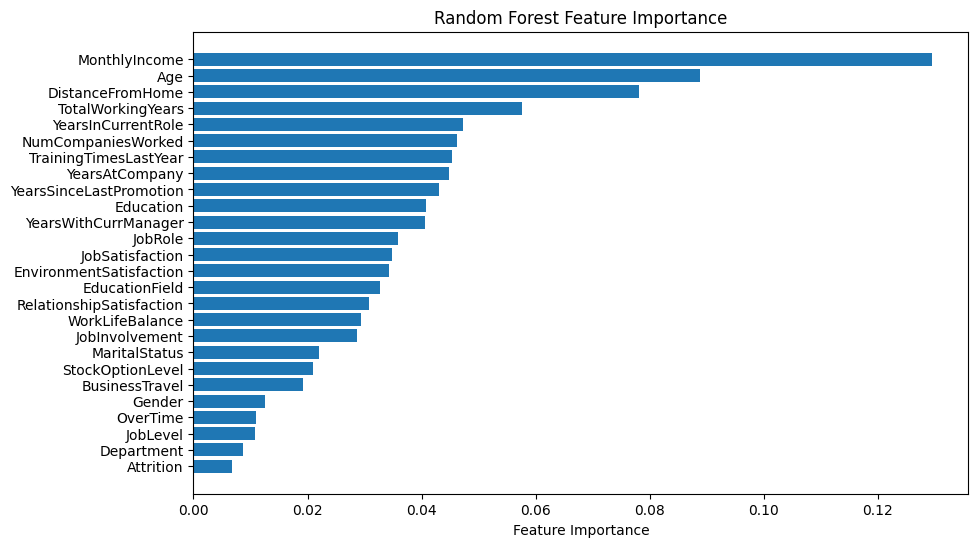

In [17]:
rf.fit(train_X, train_y)
# Get feature importances
importances = rf.feature_importances_
feature_names = train_X.columns

# Put into DataFrame
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

print(feat_imp)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [18]:
df.PerformanceRating.value_counts()

PerformanceRating
3    1244
4     226
Name: count, dtype: int64

In [22]:
y_pred = rf.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print("Baseline model RMSE:", rmse)

Baseline model RMSE: 0.37323385516094043


## Features Proxy (for f(features))

In [ ]:
def pca_weighted_score(scaled_df, features):
    """
    use PCA to determine weights for given features and compute a weighted score
    """
    
    pca = PCA(n_components=1)
    pca.fit(scaled_df[features])
    
    # use absolute values of loadings as weights
    loadings = np.abs(pca.components_[0])
    weights = loadings / loadings.sum()
    
    # calculate weighted score
    scores = scaled_df[features].values @ weights
    return scores * 100, dict(zip(features, weights))

def init_states(df):
    """
    Calculate features parameters: Skill, Motivation, Fatigue
    """
    # Skill proxies
    skill_features = ["Education", "JobLevel", "TotalWorkingYears", 
                      "TrainingTimesLastYear", "YearsInCurrentRole"]
    
    # Motivation proxies
    motivation_features = ["JobSatisfaction", "EnvironmentSatisfaction", 
                           "RelationshipSatisfaction", "JobInvolvement", "WorkLifeBalance"]
    
    # Fatigue proxies
    fatigue_features = ["OverTime", "DistanceFromHome", 
                        "YearsSinceLastPromotion", "Age", "YearsWithCurrManager"]
    
    all_features = skill_features + motivation_features + fatigue_features
    scaler = MinMaxScaler()
    scaled_all = scaler.fit_transform(df[all_features])
    scaled_df = pd.DataFrame(scaled_all, columns=all_features, index=df.index)
    
    # pca weighted scores for each parameter
    skill, skill_w = pca_weighted_score(scaled_df, skill_features)
    motivation, motivation_w = pca_weighted_score(scaled_df, motivation_features)
    fatigue, fatigue_w = pca_weighted_score(scaled_df, fatigue_features)
    
    # return results and weights
    states = pd.DataFrame({
        "Skill": skill,
        "Motivation": motivation,
        "Fatigue": fatigue
    }, index=df.index)
    
    weights = {
        "Skill": skill_w,
        "Motivation": motivation_w,
        "Fatigue": fatigue_w
    }
    
    return states, weights

          Skill  Motivation   Fatigue
1000  24.125865   43.235264  1.586082
1001  16.163750   25.290166  1.066705
1002  32.319148   78.179277  1.502927
1003  14.656183   42.953621  0.624542
1004  21.385586   50.924765  2.395041
{'Skill': {'Education': np.float64(0.13191766115059883), 'JobLevel': np.float64(0.373827093359113), 'TotalWorkingYears': np.float64(0.2799114110231758), 'TrainingTimesLastYear': np.float64(0.011265739422080218), 'YearsInCurrentRole': np.float64(0.20307809504503224)}, 'Motivation': {'JobSatisfaction': np.float64(0.3453782950192546), 'EnvironmentSatisfaction': np.float64(0.43002941160072355), 'RelationshipSatisfaction': np.float64(0.1906180968138982), 'JobInvolvement': np.float64(0.027881455581914346), 'WorkLifeBalance': np.float64(0.006092740984209271)}, 'Fatigue': {'OverTime': np.float64(0.925149704368262), 'DistanceFromHome': np.float64(0.011584465814145333), 'YearsSinceLastPromotion': np.float64(0.010594408908427414), 'Age': np.float64(0.0009951251870083109), 

## Nudging Iteration

In [ ]:
def nudging_iteration(X_states, test_y, y_pred, sigma, n_rounds=5):
    """
    Run iterative nudging simulation.
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - test_y: ground truth labels
    - y_pred: baseline predictions
    - sigma: residual standard deviation
    - n_rounds: number of iterations
    """
    current_y = test_y.copy()
    
    results = []
    
    for t in range(n_rounds):
        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Skill": X_states["Skill"].values,
        "Motivation": X_states["Motivation"].values,
        "NegFatigue": -X_states["Fatigue"].values,   # take the negative of Fatigue
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        f_centered = f_values - f_values.mean()
        
        # do(N)
        # a = 0.01
        # b = 1
        # gap = y_pred - test_y
        # mean = a*f_centered + b*gap
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(y_pred - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N
        # nudge_rating = np.clip(np.round(nudge_rating), 1, 4)

        current_y = nudge_rating.copy()
        # distances
        dist_nudge = np.mean(np.abs(nudge_rating - y_pred))
        dist_true  = np.mean(np.abs(test_y - y_pred))

        results.append({
            "round": t,
            "mean_dist_nudge": dist_nudge,
            "mean_dist_true": dist_true,
        })
    return results

In [70]:
def nudging_iteration(X_states, test_y, y_pred, sigma, n_rounds=5):
    """
    Run iterative nudging simulation.
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - test_y: ground truth labels
    - y_pred: baseline predictions
    - sigma: residual standard deviation
    - n_rounds: number of iterations
    """
    current_y = test_y.copy()
    
    results = []
    
    for t in range(n_rounds):
        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Skill": X_states["Skill"].values,
        "Motivation": X_states["Motivation"].values,
        "NegFatigue": -X_states["Fatigue"].values,   # take the negative of Fatigue
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        f_centered = f_values - f_values.mean()
        
        # do(N)
        # a = 0.01
        # b = 1
        # gap = y_pred - test_y
        # mean = a*f_centered + b*gap
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(y_pred - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N
        # nudge_rating = np.clip(np.round(nudge_rating), 1, 4)

        # (Can be change to anything) Update agent internal state based on reaction to prediction difference
        X_states["Skill"] += 0.05 * (y_pred - current_y)         
        # If the model overestimates the employee's performance (y_pred > current_y),
        # the agent may feel pressure to improve and put in more effort, leading to increased Skill.

        X_states["Motivation"] += 0.02 * (y_pred - current_y)    
        # Being overestimated may also act as a motivator, encouraging the agent to stay engaged.

        X_states["Fatigue"] += 0.03 * np.abs(y_pred - current_y) 
        # Regardless of whether the prediction is too high or too low,
        # the discrepancy can create stress or effort, resulting in higher Fatigue.


        # Clip values to keep within range [0, 1]
        X_states["Skill"] = X_states["Skill"].clip(0, 1)
        X_states["Motivation"] = X_states["Motivation"].clip(0, 1)
        X_states["Fatigue"] = X_states["Fatigue"].clip(0, 1)


        current_y = nudge_rating.copy()

        # distances

        results.append({
            "round": t,
            "mean_dist_to_y_pred": np.mean(np.abs(current_y - y_pred)),
            "mean_dist_to_test_y": np.mean(np.abs(current_y - test_y)),
            "mean_current_y": current_y.mean()
        })
        
    return results

## Iteration

In [71]:
# initialization
test_agents = test_X.copy()
states, weights = init_states(test_agents)
X_states = states[["Skill", "Motivation", "Fatigue"]]

# sigma calculation
residuals_rf = test_y - y_pred
sigma = residuals_rf.std()

# 5 iterations
results = nudging_iteration(X_states, test_y, y_pred, sigma, n_rounds=5)

for r in results:
    print(f"Round {r['round']+1}:")
    print(f"  Mean Distance (nudge vs pred): {r["mean_dist_to_y_pred"]:.3f}")
    print(f"  Mean Distance  (nudge vs test): {r["mean_dist_to_test_y"]:.3f}")
    print(f"  Mean of Rating: {r["mean_current_y"]:.3f}")


Round 1:
  Mean Distance (nudge vs pred): 0.136
  Mean Distance  (nudge vs test): 0.079
  Mean of Rating: 3.130
Round 2:
  Mean Distance (nudge vs pred): 0.091
  Mean Distance  (nudge vs test): 0.153
  Mean of Rating: 3.100
Round 3:
  Mean Distance (nudge vs pred): 0.062
  Mean Distance  (nudge vs test): 0.215
  Mean of Rating: 3.067
Round 4:
  Mean Distance (nudge vs pred): 0.065
  Mean Distance  (nudge vs test): 0.219
  Mean of Rating: 3.087
Round 5:
  Mean Distance (nudge vs pred): 0.052
  Mean Distance  (nudge vs test): 0.228
  Mean of Rating: 3.069
